In [1]:
import torch
from matplotlib import pyplot as plt

from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from lafomo.plot import Plotter, plot_phase, Colours
from experiments.lotka import build_lotka, plot_lotka
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer
import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...


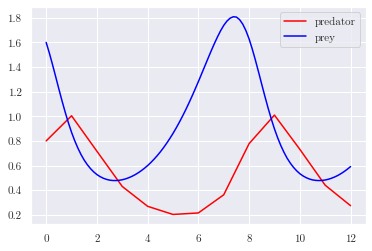

In [2]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=0.8
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

In [3]:
params = dict(
    natural=False,
    kernel='periodic'
)
lfm, trainer, plotter = build_lotka(
    dataset, params,
    # reload='../../../experiments/lotka/lotka/0savedmodel'
    reload='./twentyinducing'
)


Num training points:  13
tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([70, 1, 33])


/Users/jacob/Documents/proj/reggae/lafomo/models/variational_lfm.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [33]:
trainer.train(100, report_interval=5, step_size=1e-1)

Epoch 1201/1300 - Loss: 4.49 (3.49 1.00) kernel: [[[1.4556937]]]
Epoch 1206/1300 - Loss: 1.75 (0.77 0.97) kernel: [[[1.4275475]]]
Epoch 1211/1300 - Loss: 0.02 (-0.96 0.98) kernel: [[[1.3981344]]]
Epoch 1216/1300 - Loss: -0.20 (-1.21 1.00) kernel: [[[1.3737288]]]
Epoch 1221/1300 - Loss: -0.40 (-1.38 0.98) kernel: [[[1.3553405]]]
Epoch 1226/1300 - Loss: -0.58 (-1.57 0.99) kernel: [[[1.3459382]]]
Epoch 1231/1300 - Loss: -0.49 (-1.49 1.00) kernel: [[[1.3337678]]]
Epoch 1236/1300 - Loss: -0.54 (-1.53 0.98) kernel: [[[1.3384377]]]
Epoch 1241/1300 - Loss: -0.61 (-1.58 0.97) kernel: [[[1.3301195]]]
Epoch 1246/1300 - Loss: -0.64 (-1.60 0.96) kernel: [[[1.3278208]]]
Epoch 1251/1300 - Loss: -0.67 (-1.63 0.96) kernel: [[[1.3262243]]]
Epoch 1256/1300 - Loss: -0.74 (-1.70 0.96) kernel: [[[1.3214527]]]
Epoch 1261/1300 - Loss: -0.76 (-1.72 0.96) kernel: [[[1.3181468]]]
Epoch 1266/1300 - Loss: -0.79 (-1.75 0.96) kernel: [[[1.3166133]]]
Epoch 1271/1300 - Loss: -0.84 (-1.79 0.95) kernel: [[[1.3151053]]]


No handles with labels found to put in legend.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


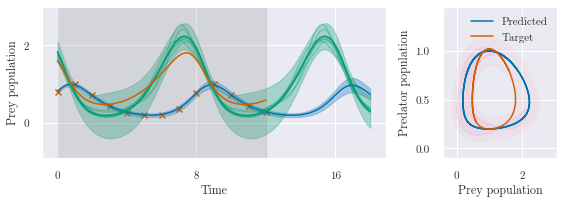

In [4]:
from pathlib import Path
plot_lotka(dataset, lfm, trainer, plotter, Path('./'), params)
# lfm.save('./twentyinducing')

No handles with labels found to put in legend.


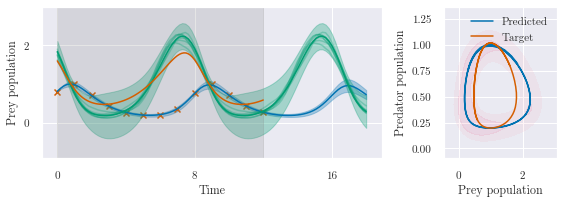

In [11]:
from matplotlib import ticker
lfm.eval()
t_predict = torch.linspace(0, 18, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.9, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Predator population')
axes[0].legend()
plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                # t_scatter=dataset.times[::5],
                # y_scatter=dataset.prey[None, None, ::5],
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].plot(dataset.times, dataset.prey, c=Colours.scatter_color, label='Target')
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3, integer=True))
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=3, integer=True))
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')

real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1])
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
plt.tight_layout()

# labels = ['Initial', 'Grown rates', 'Decay rates']
# kinetics = list()
# for key in ['raw_initial', 'raw_growth', 'raw_decay']:
#     kinetics.append(softplus(torch.tensor(trainer.parameter_trace[key][-1])).squeeze().numpy())
#
# plotter.plot_double_bar(kinetics, labels)

In [26]:
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))
with torch.no_grad():
    # lfm.raw_growth += 0.2  1.2179
    # lfm.gp_model.covar_module.base_kernel.lengthscale -= 0.2
    lfm.gp_model.covar_module.outputscale += 0.3
    print(lfm.gp_model.covar_module.outputscale)
    # lfm.gp_model.covar_module.base_kernel.period_length -= 0.2
    # print(lfm.gp_model.covar_module.base_kernel.lengthscale)

tensor([[0.6089]], dtype=torch.float64) tensor([[0.6152]], dtype=torch.float64)
{'constant': Parameter containing:
tensor([[0.4541]], dtype=torch.float64)}
tensor([0.7746], dtype=torch.float64)


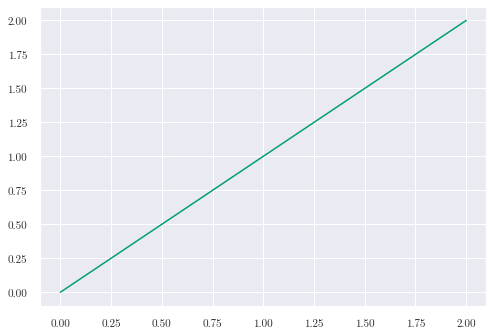

In [8]:
import seaborn as sns

sns.color_palette('colorblind')
plt.plot([0, 2], [0, 2], c=Colours.bar2_color)

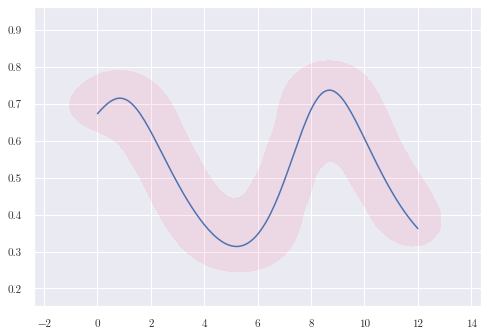

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())